**Connect and Download Dataset from Kaggle**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nivyasreejith","key":"c1be403792117090d389f4a7e3fbd11c"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [5]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 99% 1.97G/1.98G [00:26<00:00, 280MB/s]
100% 1.98G/1.98G [00:26<00:00, 79.3MB/s]


In [6]:
!unzip fruit-and-vegetable-image-recognition.zip -d fruit_veg_data

Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: fruit_veg_data/test/apple/Image_1.jpg  
  inflating: fruit_veg_data/test/apple/Image_10.jpg  
  inflating: fruit_veg_data/test/apple/Image_2.jpg  
  inflating: fruit_veg_data/test/apple/Image_3.jpg  
  inflating: fruit_veg_data/test/apple/Image_4.jpg  
  inflating: fruit_veg_data/test/apple/Image_5.jpg  
  inflating: fruit_veg_data/test/apple/Image_6.JPG  
  inflating: fruit_veg_data/test/apple/Image_7.jpg  
  inflating: fruit_veg_data/test/apple/Image_8.jpg  
  inflating: fruit_veg_data/test/apple/Image_9.jpg  
  inflating: fruit_veg_data/test/banana/Image_1.jpg  
  inflating: fruit_veg_data/test/banana/Image_10.jpg  
  inflating: fruit_veg_data/test/banana/Image_2.jpg  
  inflating: fruit_veg_data/test/banana/Image_3.jpg  
  inflating: fruit_veg_data/test/banana/Image_4.jpg  
  inflating: fruit_veg_data/test/banana/Image_5.jpg  
  inflating: fruit_veg_data/test/banana/Image_6.jpg  
  inflating: fruit_veg_data/test/banan

**Check Folder Structure**

In [7]:
import os
os.listdir('fruit_veg_data')

['test', 'train', 'validation']

In [8]:
# Base dataset directory
data_dir = '/content/fruit_veg_data'

# Define paths
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'validation')

# Check structure
print("Train samples:", len(os.listdir(train_dir)))
print("Test samples:", len(os.listdir(test_dir)))
print("Validation samples:", len(os.listdir(val_dir)))

Train samples: 36
Test samples: 36
Validation samples: 36


**Load and preprocess images**

In [10]:
import glob
import numpy as np
from tensorflow.keras.preprocessing import image

# Define fruit classes
fruit_classes = ['apple', 'banana', 'pear', 'grapes', 'orange', 'kiwi',
                 'watermelon', 'pomegranate', 'pineapple', 'mango']

def load_data(directory):
    X = []
    y_labels = []
    class_names_list = []
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            label = 0 if cls.lower() in fruit_classes else 1  # 0=Fruit, 1=Vegetable
            for img_path in glob.glob(os.path.join(cls_path, '*')):
                img = image.load_img(img_path, target_size=(128,128))
                img_array = image.img_to_array(img)/255.0
                X.append(img_array)
                y_labels.append(label)
                class_names_list.append(cls)
    return np.array(X), np.array(y_labels), class_names_list

# Load datasets
X_train, y_train, train_names = load_data(train_dir)
X_val, y_val, val_names = load_data(val_dir)
X_test, y_test, test_names = load_data(test_dir)

print("✅ Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)



/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ Train: (3115, 128, 128, 3) Validation: (351, 128, 128, 3) Test: (359, 128, 128, 3)


**Convert class names to numeric indices for multi-class**

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Combine all class names to get all unique labels
all_classes = sorted(list(set(train_names + val_names + test_names)))

label_encoder = LabelEncoder()
label_encoder.fit(all_classes)

# Convert names to numeric labels
y_train_numeric = label_encoder.transform(train_names)
y_val_numeric = label_encoder.transform(val_names)
y_test_numeric = label_encoder.transform(test_names)

# One-hot encode for multi-class classification
y_train_cat = to_categorical(y_train_numeric, num_classes=len(all_classes))
y_val_cat = to_categorical(y_val_numeric, num_classes=len(all_classes))
y_test_cat = to_categorical(y_test_numeric, num_classes=len(all_classes))


**Build multi-class CNN**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(all_classes), activation='softmax')  # Multi-class output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Train the model**

In [13]:
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_cat)
)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.0417 - loss: 3.5470 - val_accuracy: 0.2251 - val_loss: 2.9089
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.1405 - loss: 3.1066 - val_accuracy: 0.3533 - val_loss: 2.2998
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.1984 - loss: 2.7509 - val_accuracy: 0.4501 - val_loss: 1.9672
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 995ms/step - accuracy: 0.2430 - loss: 2.5473 - val_accuracy: 0.5185 - val_loss: 1.8107
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 97s 983ms/step - accuracy: 0.2802 - loss: 2.3643 - val_accuracy: 0.5613 - val_loss: 1.6968
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3135 - loss: 2.1989 - val_accuracy: 0.6439 - val_loss: 1.3447
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 97s 991ms/step - accuracy: 0.3848 - loss: 2.0299 - val_accuracy: 0.7037 - val_loss: 1.1874
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4192 - loss: 1.8944 - val_accuracy: 0.740

**Predict on test images and show category**

In [14]:
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis=1)

print("\n🔍 Sample Predictions:")
for i in range(10):  # first 10 predictions
    predicted_name = label_encoder.inverse_transform([pred_classes[i]])[0]
    category = "Fruit" if predicted_name.lower() in fruit_classes else "Vegetable"
    print(f"Predicted item: {predicted_name} → Category: {category}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step

🔍 Sample Predictions:
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: kiwi → Category: Fruit
Predicted item: peas → Category: Vegetable
Predicted item: kiwi → Category: Fruit


**Visualize Predictions with Matplotlib**

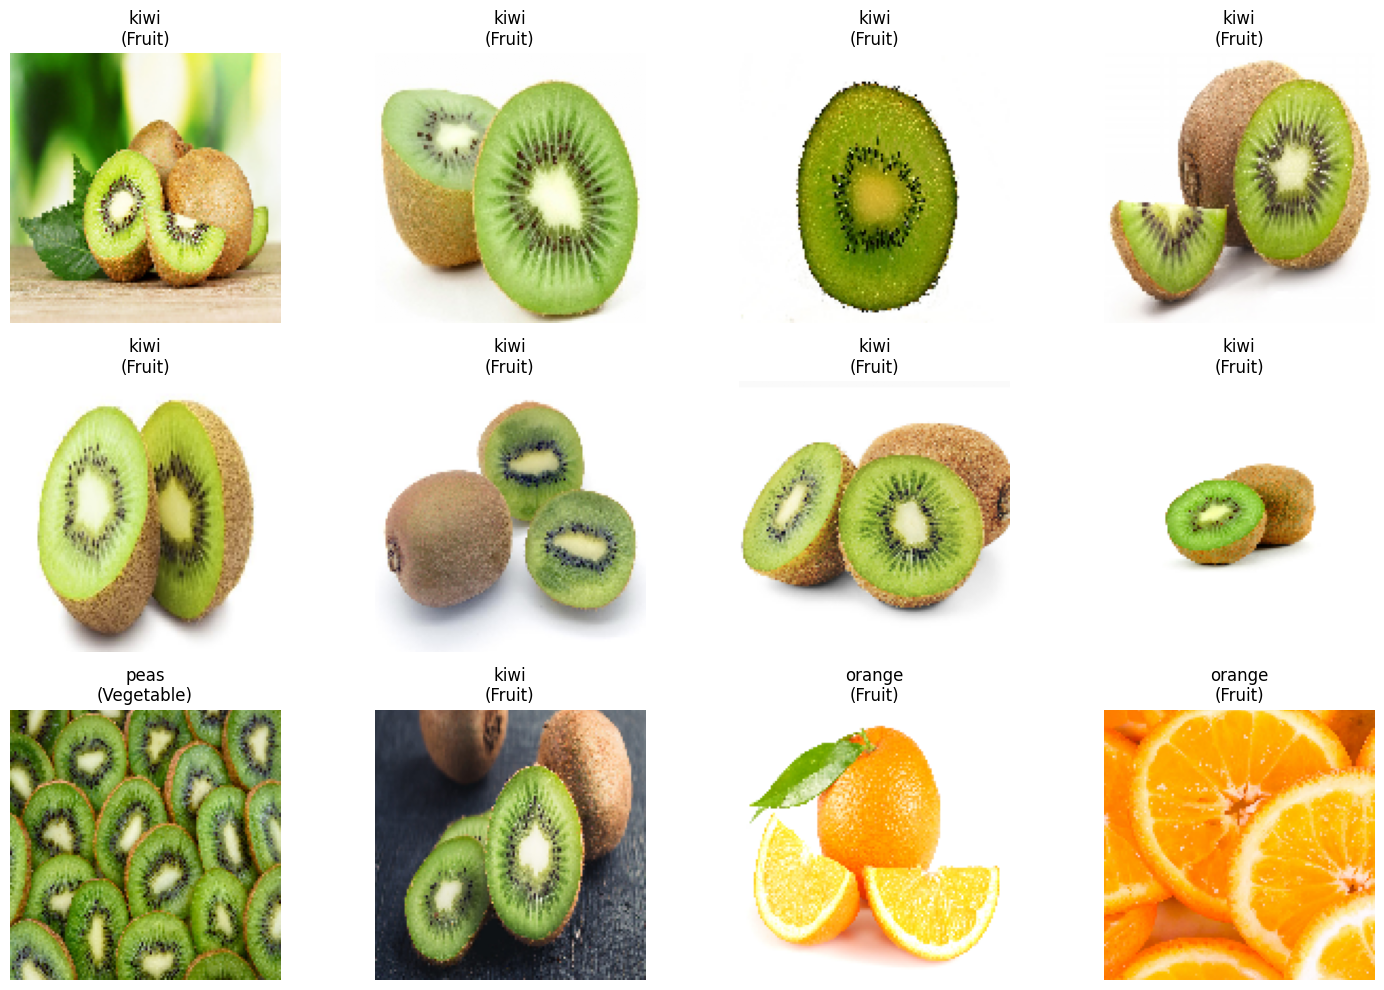

In [15]:
import matplotlib.pyplot as plt

# Number of test images to display
num_display = 12

plt.figure(figsize=(15, 10))

for i in range(num_display):
    img = X_test[i]
    predicted_name = label_encoder.inverse_transform([pred_classes[i]])[0]
    category = "Fruit" if predicted_name.lower() in fruit_classes else "Vegetable"

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"{predicted_name}\n({category})")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Upload & Predict Fruit vs Vegetable**

Saving carrot.webp to carrot (1).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


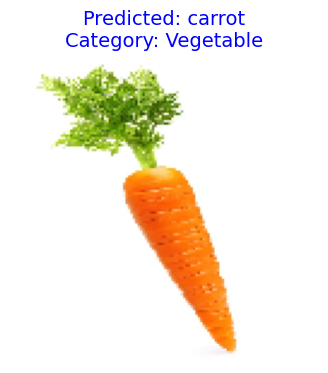

In [20]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and preprocess the image
    img = image.load_img(filename, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred = model.predict(img_array_exp)
    pred_class = np.argmax(pred, axis=1)[0]

    # Get predicted item name
    predicted_name = label_encoder.inverse_transform([pred_class])[0]

    # Determine category
    category = "Fruit" if predicted_name.lower() in fruit_classes else "Vegetable"

    # Display image with prediction
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_name}\nCategory: {category}", fontsize=14, color='blue')
    plt.show()



Saving mango.jpg to mango.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


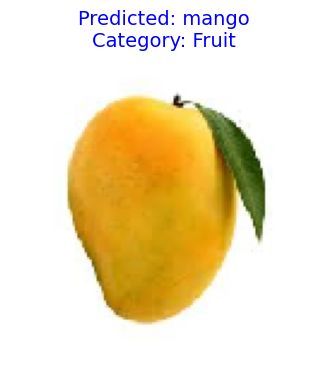

In [21]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and preprocess the image
    img = image.load_img(filename, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred = model.predict(img_array_exp)
    pred_class = np.argmax(pred, axis=1)[0]

    # Get predicted item name
    predicted_name = label_encoder.inverse_transform([pred_class])[0]

    # Determine category
    category = "Fruit" if predicted_name.lower() in fruit_classes else "Vegetable"

    # Display image with prediction
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_name}\nCategory: {category}", fontsize=14, color='blue')
    plt.show()
